### Deep Learning - Project 21
#### Week 4:
This week we are going to adapt our model (and code) to support the structured tensor aproach in paper [3] (Jackowski, K., & Cyganek, B. (2017). A learning-based colour image segmentation with extended and compact structural tensor feature representation. Pattern Analysis and Applications, 20(2), 401–414. https://doi.org/10.1007/s10044-015-0502-2).

There will be no changes to the model (except how many inputs it has). We will simply represent the grayscale image across 3 gradients in 2 directions, associating each image to extra 3 channels (4 in total). Then our model will take this 4 channels, 3 of them with contextual information, and hopefully improve the results we already saw.

In [ ]:
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image, UnidentifiedImageError
import torch
from torchvision import transforms
from torch.utils.data import TensorDataset, random_split, DataLoader
from scipy.ndimage import gaussian_filter
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from skimage.filters import threshold_otsu
from scipy.ndimage import gaussian_filter, map_coordinates, sobel
import cv2
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Only run when training the SIMUPOR dataset
!cp -r /content/drive/MyDrive/SIMUPOR/test /content/SIMUPOR

#### Step 1:
First we have to download the SIMUPOR data and process it the same way as before. But we need to calculate the gradients, after denoising and normalising the image. Also need to do the nonlinear anisotropic diffusion (Perona–Malik) with Tukey bi-weight diffusivity (for the three gradients). This function doesn't change much of the gradient value but it is done in the paper, so its important that we do it aswell. Bellow we simply load the images like before.

In [ ]:
images_path = "/content/drive/MyDrive/SIMUPOR/test/images"
masks_path  = "/content/drive/MyDrive/SIMUPOR/test/masks"

image_files = sorted(os.listdir(images_path))
mask_files  = sorted(os.listdir(masks_path))

# List to hold all image tensors
image_list = []
mask_list = []

for img_file, mask_file in zip(image_files, mask_files):
    img_path = os.path.join(images_path, img_file)
    mask_path = os.path.join(masks_path, mask_file)

    if not (img_file.lower().endswith(".png") and mask_file.lower().endswith(".npy")):
        continue

    # Verify if the file is valid
    try:
        with Image.open(img_path) as tmp:
            tmp.verify()
    except (UnidentifiedImageError, OSError):
        continue

    image_list.append(img_path)
    mask_list.append(mask_path)


print("Loaded:")
print("Images:", len(image_list))
print("Masks:", len(mask_list))

Loaded:
Images: 6912
Masks: 6912


Now we change the SimuporDataset class to compute the gradients immediately. A Tukey Diffusion function is made to copy the method used in the paper.

In [ ]:
# Compute the tukey diffusion like the paper does
def tukey_diffusion_gradient(grad, iterations=15, step_size=0.1):
    grad = grad.astype(np.float32)

    for _ in range(iterations):
        # Compute gradient of gradient (for the scale)
        gx = sobel(grad, axis=1)
        gy = sobel(grad, axis=0)
        mag = np.sqrt(gx**2 + gy**2)

        # Robust scale
        med = np.median(mag)
        r = 1.4826 * np.median(np.abs(mag - med))

        # Tukey biweight diffusivity
        c = np.zeros_like(mag)
        mask = mag <= r
        c[mask] = 0.5 * (1 - (mag[mask] / r)**2)**2

        # Diffusion flux
        Fx = c * gx
        Fy = c * gy

        # Divergence
        div = (sobel(Fx, axis=1) + sobel(Fy, axis=0)) / 8.0

        # Update gradient
        grad = grad + step_size * div

    return grad

# We put the images into a DataSet that formats them the way we want already
class SimuporDataset(Dataset):
    def __init__(self, image_paths, mask_paths, sigma=1.0, ad_iters = 15):
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        self.sigma       = sigma
        self.ad_iters    = ad_iters

    def normalize01(self, arr):
        return (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)

    def compute_gradients(self, img):
        gx = sobel(img, axis=1)   # ∂I/∂x
        gy = sobel(img, axis=0)   # ∂I/∂y
        return gx, gy

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):

        # Load grayscale
        img = Image.open(self.image_paths[idx]).convert("L")
        img_np = np.array(img, dtype=np.float32)

        # Normalize + Gaussian smoothing
        img_norm = self.normalize01(img_np)
        img_smooth = gaussian_filter(img_norm, sigma=self.sigma)

        # Gradients and tukey_diffusion
        Ix, Iy = self.compute_gradients(img_smooth)
        Ix = tukey_diffusion_gradient(Ix, iterations=self.ad_iters)
        Iy = tukey_diffusion_gradient(Iy, iterations=self.ad_iters)
        Ixx = Ix * Ix
        Iyy = Iy * Iy
        Ixy = Ix * Iy

        # Normalize all channels
        I   = self.normalize01(img_smooth)
        Ixx = self.normalize01(Ixx)
        Ixy = self.normalize01(Ixy)
        Iyy = self.normalize01(Iyy)

        # 4-channel input
        stacked = np.stack([I, Ixx, Iyy, Ixy], axis=0)
        img_tensor = torch.tensor(stacked, dtype=torch.float32)

        # Mask
        mask_np = np.load(self.mask_paths[idx]).astype(np.float32)
        mask_np = (mask_np > 0).astype(np.float32)
        mask_tensor = torch.tensor(mask_np).unsqueeze(0)

        return img_tensor, mask_tensor


# 65% train, 35% temp
train_imgs, temp_imgs, train_masks, temp_masks = train_test_split(image_list, mask_list, test_size=0.35, random_state=42)

# 35% split into 15% val, 20% test
val_imgs, test_imgs, val_masks, test_masks = train_test_split(temp_imgs, temp_masks, test_size=0.5714, random_state=42)

print("Train:", len(train_imgs))
print("Val:  ", len(val_imgs))
print("Test: ", len(test_imgs))

# Pre-process the data
train_dataset = SimuporDataset(train_imgs, train_masks, sigma=1.0)
val_dataset   = SimuporDataset(val_imgs, val_masks, sigma=1.0)
test_dataset  = SimuporDataset(test_imgs, test_masks, sigma=1.0)

# Load the data in small batches
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=16, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=16, num_workers=2)


Train: 4492
Val:   1037
Test:  1383


Below we can see how the images and their gradients.

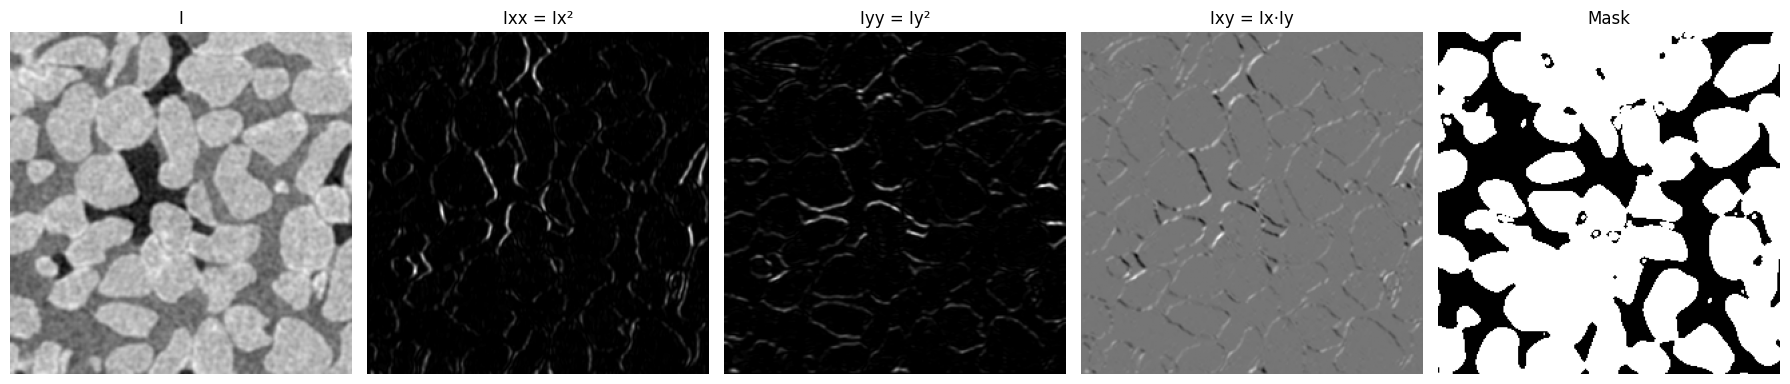

In [ ]:
# Choose the image here
index = 0

# Selecting the images
img_tensor, mask_tensor = train_dataset[index]
img_np  = img_tensor.numpy()
mask_np = mask_tensor.squeeze().numpy()

# Ploting the images
channel_names = ["I","Ixx = Ix²","Iyy = Iy²","Ixy = Ix·Iy"]
plt.figure(figsize=(18, 4))

# 4 channels
for i in range(4):
    plt.subplot(1, 5, i+1)
    plt.imshow(img_np[i], cmap='gray')
    plt.title(channel_names[i])
    plt.axis("off")

# Mask
plt.subplot(1, 5, 5)
plt.imshow(mask_np, cmap='gray')
plt.title("Mask")
plt.axis("off")
plt.tight_layout()
plt.show()

#### Step 2
Now we redefine the U-net model to accept 4-dimensioal input, like the ones we have. The decoder portion will be the same since we still only have one target. The following code just uses the definitions done in the Week 1 notebook, so no need to explain again.

In [ ]:
def double_convolution(in_channels, out_channels):
    """
    In the original paper implementation, the convolution operations were
    not padded but we are padding them here. This is because, we need the
    output result size to be same as input size.
    """
    conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )
    return conv_op

class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # Contracting path.
        # Each convolution is applied twice.
        self.down_convolution_1 = double_convolution(4, 64)          # only change was done here
        self.down_convolution_2 = double_convolution(64, 128)
        self.down_convolution_3 = double_convolution(128, 256)
        self.down_convolution_4 = double_convolution(256, 512)
        self.down_convolution_5 = double_convolution(512, 1024)
        # Expanding path.
        self.up_transpose_1 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=512,
            kernel_size=2,
            stride=2)
        # Below, `in_channels` again becomes 1024 as we are concatinating.
        self.up_convolution_1 = double_convolution(1024, 512)
        self.up_transpose_2 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256,
            kernel_size=2,
            stride=2)
        self.up_convolution_2 = double_convolution(512, 256)
        self.up_transpose_3 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128,
            kernel_size=2,
            stride=2)
        self.up_convolution_3 = double_convolution(256, 128)
        self.up_transpose_4 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64,
            kernel_size=2,
            stride=2)
        self.up_convolution_4 = double_convolution(128, 64)
        # output => `out_channels` as per the number of classes.
        self.out = nn.Conv2d(
            in_channels=64, out_channels=num_classes,
            kernel_size=1
        )
    def forward(self, x):
        down_1 = self.down_convolution_1(x)
        down_2 = self.max_pool2d(down_1)
        down_3 = self.down_convolution_2(down_2)
        down_4 = self.max_pool2d(down_3)
        down_5 = self.down_convolution_3(down_4)
        down_6 = self.max_pool2d(down_5)
        down_7 = self.down_convolution_4(down_6)
        down_8 = self.max_pool2d(down_7)
        down_9 = self.down_convolution_5(down_8)
        # *** DO NOT APPLY MAX POOL TO down_9 ***

        up_1 = self.up_transpose_1(down_9)
        x = self.up_convolution_1(torch.cat([down_7, up_1], 1))
        up_2 = self.up_transpose_2(x)
        x = self.up_convolution_2(torch.cat([down_5, up_2], 1))
        up_3 = self.up_transpose_3(x)
        x = self.up_convolution_3(torch.cat([down_3, up_3], 1))
        up_4 = self.up_transpose_4(x)
        x = self.up_convolution_4(torch.cat([down_1, up_4], 1))
        out = self.out(x)
        return out


def dice_loss(pred, target, smooth = 1.0):
    # Apply sigmoid to convert logits to probabilities
    pred = torch.sigmoid(pred)

    # Calculate intersection and union
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))

    # Compute Dice Coefficient
    dice = (2. * intersection + smooth) / (union + smooth)

    # Return Dice Loss
    return 1 - dice.mean()

bce = nn.BCEWithLogitsLoss() # combines a Sigmoid layer and the Binary Cross Entropy between the target and the input probabilities

# we combine the dice loss and the bce loss
def combined_loss(pred, target, alpha=0.5):
    """
    alpha: weight for Dice vs CE
    """
    return alpha * dice_loss(pred, target) + (1 - alpha) * bce(pred, target)

def dice_coefficient(pred, target):
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2. * intersection) / (union + 1e-6)
    return dice.item()

model = UNet(num_classes = 1) #Each pixel’s value represents the probability of being the foreground (pore)

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

####
So now we run the model and train it (hopefully it wild wield a better dice score).

In [ ]:
model = model.to(device)

loss_fn = combined_loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10
validation_every_steps = 5
step = 0

train_dice_scores = []
valid_dice_scores = []
train_losses = []
valid_losses = []

best_val_dice = 0.0
model.train()

for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward + loss + backward
        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()

        # Compute thresholded Dice for this batch
        preds = (torch.sigmoid(output) > 0.5).float()
        batch_dice = dice_coefficient(preds, targets)
        train_dice_scores.append(batch_dice)
        train_losses.append(loss.item())

        step += 1

        # Validation every N steps
        if step % validation_every_steps == 0:
            model.eval()
            val_dice_list = []
            val_loss_list = []

            with torch.no_grad():
                for val_inputs, val_targets in val_loader:
                    val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                    val_output = model(val_inputs)
                    val_loss = loss_fn(val_output, val_targets)

                    val_preds = (torch.sigmoid(val_output) > 0.5).float()
                    val_dice = dice_coefficient(val_preds, val_targets)

                    val_dice_list.append(val_dice)
                    val_loss_list.append(val_loss.item())

            mean_val_dice = np.mean(val_dice_list)
            mean_val_loss = np.mean(val_loss_list)
            valid_dice_scores.append(mean_val_dice)
            valid_losses.append(mean_val_loss)

            # Save best model
            if mean_val_dice > best_val_dice:
                best_val_dice = mean_val_dice
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'epoch': epoch+1
                }, "/content/drive/MyDrive/SIMUPOR/unet_simupor_checkpoint_tensor.pth")

            print(f"Epoch {epoch+1}, Step {step:<5} | "
                  f"Train Dice: {batch_dice:.4f} | Val Dice: {mean_val_dice:.4f} | Val Loss: {mean_val_loss:.4f}")

            model.train()

print("Finished training.")

Epoch 1, Step 5     | Train Dice: 0.8603 | Val Dice: 0.8529 | Val Loss: 0.3495
Epoch 1, Step 10    | Train Dice: 0.9191 | Val Dice: 0.9073 | Val Loss: 0.2674
Epoch 1, Step 15    | Train Dice: 0.8600 | Val Dice: 0.9050 | Val Loss: 0.2711
Epoch 1, Step 20    | Train Dice: 0.8955 | Val Dice: 0.8849 | Val Loss: 0.2734
Epoch 1, Step 25    | Train Dice: 0.8899 | Val Dice: 0.8937 | Val Loss: 0.2619
Epoch 1, Step 30    | Train Dice: 0.8944 | Val Dice: 0.8973 | Val Loss: 0.2623
Epoch 1, Step 35    | Train Dice: 0.8887 | Val Dice: 0.8999 | Val Loss: 0.2578
Epoch 1, Step 40    | Train Dice: 0.9032 | Val Dice: 0.9010 | Val Loss: 0.2600
Epoch 1, Step 45    | Train Dice: 0.8965 | Val Dice: 0.9017 | Val Loss: 0.2507
Epoch 1, Step 50    | Train Dice: 0.9040 | Val Dice: 0.9023 | Val Loss: 0.2471
Epoch 1, Step 55    | Train Dice: 0.9098 | Val Dice: 0.9048 | Val Loss: 0.2446
Epoch 1, Step 60    | Train Dice: 0.9104 | Val Dice: 0.9075 | Val Loss: 0.2455
Epoch 1, Step 65    | Train Dice: 0.9006 | Val Dice:

KeyboardInterrupt: 

We can calculate the dice score for the testing dataset.

In [ ]:
# Uploading the weights from Drive
weights_path = "/content/drive/MyDrive/SIMUPOR/unet_simupor_checkpoint_tensor.pth"

device = "cuda" if torch.cuda.is_available() else "cpu"

# Creates a new model and uploads the weights to it
model = UNet(num_classes=1).to(device)

checkpoint = torch.load(weights_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])

print("Weights loaded successfully")

# Testing result
model.eval()
test_dice_values = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        preds = (torch.sigmoid(output) > 0.5).float()
        dice = dice_coefficient(preds, targets)
        test_dice_values.append(dice)

mean_test_dice = np.mean(test_dice_values)
var_test_dice  = np.var(test_dice_values)

print(f"Test dice score (mean): {mean_test_dice:.3f}       Test dice score (var): {var_test_dice:.3f}")

Weights loaded successfully
Test dice score (mean): 0.922       Test dice score (var): 0.000


And also need to compute the IoU score to able to compare with the SIMUPOR paper.

In [ ]:
def iou_score(pred, target, eps=1e-6):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + eps) / (union + eps)

# Uploading the weights from Drive
weights_path = "/content/drive/MyDrive/SIMUPOR/unet_simupor_checkpoint_tensor.pth"

device = "cuda" if torch.cuda.is_available() else "cpu"

# Creates a new model and uploads the weights to it
model = UNet(num_classes=1).to(device)

checkpoint = torch.load(weights_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])

print("Weights loaded successfully")

with torch.no_grad():
    model.eval()
    test_iou = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        output = model(inputs)
        loss = combined_loss(output, targets)

        preds = torch.sigmoid(output)
        iou = iou_score(preds, targets).item()
        test_iou.append(iou)

    test_iou = np.mean(test_iou)
    var_test = np.var(test_iou)

    print(f"Test IoU score (mean): {test_iou:.3f}       Test IoU score (var): {var_test:.3f}")

    model.train()

Weights loaded successfully
Test IoU score (mean): 0.856       Test IoU score (var): 0.000


We can check the models progress below.

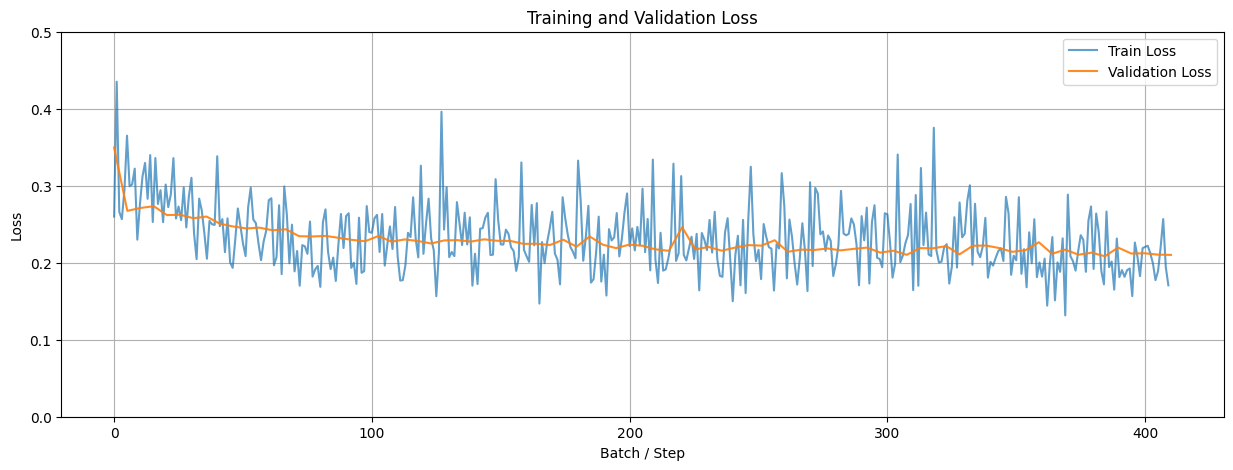

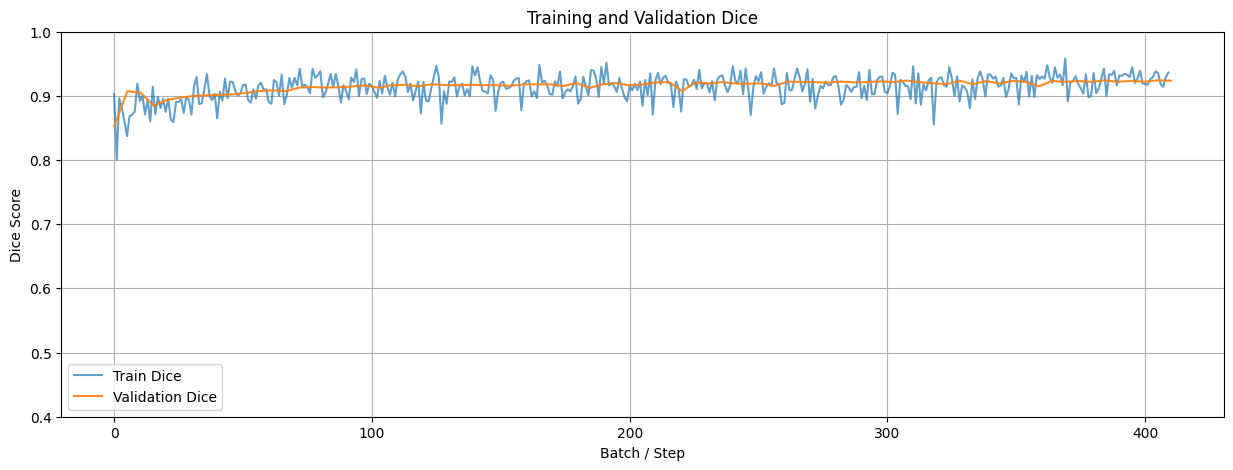

In [ ]:
# Loss plot
plt.figure(figsize=(15, 5))
plt.plot(train_losses, label='Train Loss', alpha=0.7)
plt.plot(np.linspace(0, len(train_losses), len(valid_losses)), valid_losses, label='Validation Loss', alpha=0.9)
plt.xlabel('Batch / Step')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.ylim([0 , 0.5])
plt.show()

# Dice plot
plt.figure(figsize=(15, 5))
plt.plot(train_dice_scores, label='Train Dice', alpha=0.7)
plt.plot(np.linspace(0, len(train_dice_scores), len(valid_dice_scores)), valid_dice_scores, label='Validation Dice', alpha=0.9)
plt.xlabel('Batch / Step')
plt.ylabel('Dice Score')
plt.title('Training and Validation Dice')
plt.legend()
plt.grid(True)
plt.ylim([0.4 , 1])
plt.show()

And see how it behaves up close.

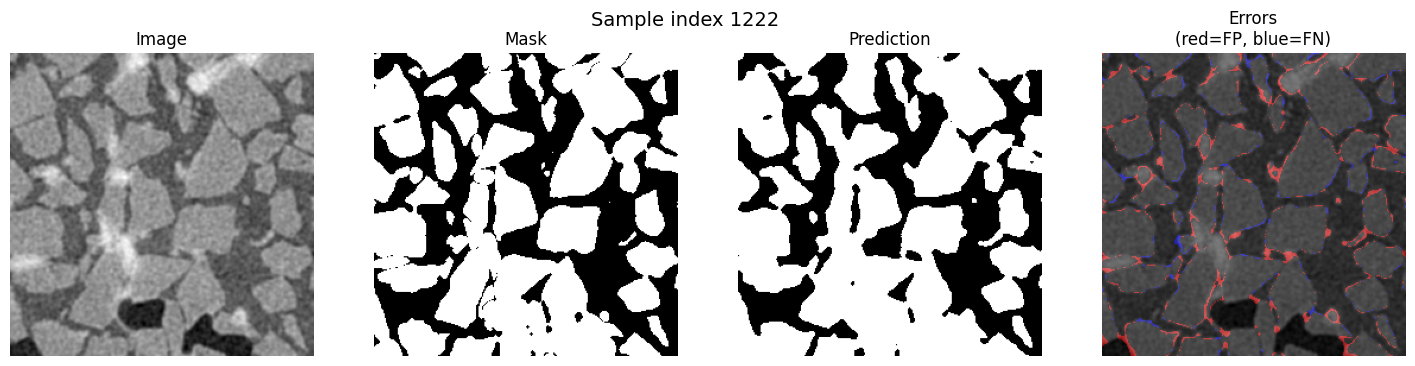

In [ ]:
model.eval()

# Choose a single test sample index
idx = np.random.randint(len(test_dataset))

# Load sample
img_tensor, gt_mask = test_dataset[idx]
img = img_tensor.unsqueeze(0).to(device)

# Prediction
with torch.no_grad():
    output = model(img)
    pred = (torch.sigmoid(output) > 0.5).float().squeeze().cpu().numpy()

# Convert to numpy
img_np = img_tensor.squeeze().numpy()
img_np = img_np[0]
gt_np  = gt_mask.squeeze().numpy()

# Intersection (True Positives)
intersection = pred * gt_np

# Error regions
false_pos = (pred == 1) & (gt_np == 0)  # red
false_neg = (pred == 0) & (gt_np == 1)  # blue

error_map = np.zeros((*gt_np.shape, 3))
error_map[false_pos] = [1, 0, 0]  # red
error_map[false_neg] = [0, 0, 1]  # blue

# Plot all 4 images
plt.figure(figsize=(18,4))
plt.suptitle(f"Sample index {idx}", fontsize=14)

# Raw image
plt.subplot(1,4,1)
plt.imshow(img_np, cmap="gray")
plt.title("Image")
plt.axis("off")

# Ground truth
plt.subplot(1,4,2)
plt.imshow(gt_np, cmap="gray")
plt.title("Mask")
plt.axis("off")

# Prediction
plt.subplot(1,4,3)
plt.imshow(pred, cmap="gray")
plt.title("Prediction")
plt.axis("off")

# Intersection + Error overlay
plt.subplot(1,4,4)
plt.imshow(img_np, cmap="gray")
plt.imshow(error_map, alpha=0.5)
plt.title("Errors\n(red=FP, blue=FN)")
plt.axis("off")

plt.show()

#### Step 3
Now we can apply the trained model to the tomography data. We use the same code as in the week 3 notebook, but now we compute the gradients like above.

####
Some functions used here (just repetitions of previously used functions so we cun run the training loop independently)

In [ ]:
def normalize_and_denoise(img_np, sigma = 1):
        img_norm = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)
        img_denoised = gaussian_filter(img_norm, sigma=sigma)
        return img_denoised

# Removing the pixels that are lighter than the background
def background_from_image(img_np, mask_np):
    binary_mask = (mask_np < img_np).astype(np.uint8)
    return binary_mask

# Guided Otsu
def guided_otsu(img_np, mask_np):
    img_bg_thresh = threshold_otsu(img_np)
    background_pixels = mask_np[img_np < img_bg_thresh]
    if len(background_pixels) == 0:
        mask_thresh = threshold_otsu(mask_np)
    else:
        mask_thresh = threshold_otsu(background_pixels)
    binary_mask = (mask_np > mask_thresh).astype(np.uint8)
    binary_mask = 1 - binary_mask
    return binary_mask

# Intercept the two methods
def combined_mask(img_np, mask_np):
    # Two methods
    mask_guided = guided_otsu(img_np, mask_np)
    mask_bg = background_from_image(img_np, mask_np)

    # Intersection
    final = (mask_guided & mask_bg).astype(np.uint8)
    return final

def normalize01(arr):
        return (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)

def compute_gradients(img):
    gx = sobel(img, axis=1)   # ∂I/∂x
    gy = sobel(img, axis=0)   # ∂I/∂y
    return gx, gy

def tukey_diffusion_gradient(grad, iterations=15, step_size=0.1):
    grad = grad.astype(np.float32)

    for _ in range(iterations):
        # Compute gradient of gradient (for the scale)
        gx = sobel(grad, axis=1)
        gy = sobel(grad, axis=0)
        mag = np.sqrt(gx**2 + gy**2)

        # Robust scale
        med = np.median(mag)
        r = 1.4826 * np.median(np.abs(mag - med))

        # Tukey biweight diffusivity
        c = np.zeros_like(mag)
        mask = mag <= r
        c[mask] = 0.5 * (1 - (mag[mask] / r)**2)**2

        # Diffusion flux
        Fx = c * gx
        Fy = c * gy

        # Divergence
        div = (sobel(Fx, axis=1) + sobel(Fy, axis=0)) / 8.0

        # Update gradient
        grad = grad + step_size * div

    return grad

def preprocess_unlabeled(img_np, target_size=(768, 768), sigma=1):

    # Centered crop parameters
    H, W = img_np.shape
    crop_H, crop_W = 768, 768  # adjusted to the size of the labeled images

    ymin = (H - crop_H) // 2
    ymax = ymin + crop_H
    xmin = (W - crop_W) // 2
    xmax = xmin + crop_W

    # Apply Crop
    cropped = img_np[ymin:ymax, xmin:xmax]

    # Normalize and denoise
    preprocessed = normalize_and_denoise(cropped)
    return preprocessed

def double_convolution(in_channels, out_channels):
    """
    In the original paper implementation, the convolution operations were
    not padded but we are padding them here. This is because, we need the
    output result size to be same as input size.
    """
    conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )
    return conv_op

class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # Contracting path.
        # Each convolution is applied twice.
        self.down_convolution_1 = double_convolution(4, 64)          # only change was done here
        self.down_convolution_2 = double_convolution(64, 128)
        self.down_convolution_3 = double_convolution(128, 256)
        self.down_convolution_4 = double_convolution(256, 512)
        self.down_convolution_5 = double_convolution(512, 1024)
        # Expanding path.
        self.up_transpose_1 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=512,
            kernel_size=2,
            stride=2)
        # Below, `in_channels` again becomes 1024 as we are concatinating.
        self.up_convolution_1 = double_convolution(1024, 512)
        self.up_transpose_2 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256,
            kernel_size=2,
            stride=2)
        self.up_convolution_2 = double_convolution(512, 256)
        self.up_transpose_3 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128,
            kernel_size=2,
            stride=2)
        self.up_convolution_3 = double_convolution(256, 128)
        self.up_transpose_4 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64,
            kernel_size=2,
            stride=2)
        self.up_convolution_4 = double_convolution(128, 64)
        # output => `out_channels` as per the number of classes.
        self.out = nn.Conv2d(
            in_channels=64, out_channels=num_classes,
            kernel_size=1
        )
    def forward(self, x):
        down_1 = self.down_convolution_1(x)
        down_2 = self.max_pool2d(down_1)
        down_3 = self.down_convolution_2(down_2)
        down_4 = self.max_pool2d(down_3)
        down_5 = self.down_convolution_3(down_4)
        down_6 = self.max_pool2d(down_5)
        down_7 = self.down_convolution_4(down_6)
        down_8 = self.max_pool2d(down_7)
        down_9 = self.down_convolution_5(down_8)
        # *** DO NOT APPLY MAX POOL TO down_9 ***

        up_1 = self.up_transpose_1(down_9)
        x = self.up_convolution_1(torch.cat([down_7, up_1], 1))
        up_2 = self.up_transpose_2(x)
        x = self.up_convolution_2(torch.cat([down_5, up_2], 1))
        up_3 = self.up_transpose_3(x)
        x = self.up_convolution_3(torch.cat([down_3, up_3], 1))
        up_4 = self.up_transpose_4(x)
        x = self.up_convolution_4(torch.cat([down_1, up_4], 1))
        out = self.out(x)
        return out


def dice_loss(pred, target, smooth = 1.0):
    # Apply sigmoid to convert logits to probabilities
    pred = torch.sigmoid(pred)

    # Calculate intersection and union
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))

    # Compute Dice Coefficient
    dice = (2. * intersection + smooth) / (union + smooth)

    # Return Dice Loss
    return 1 - dice.mean()

bce = nn.BCEWithLogitsLoss() # combines a Sigmoid layer and the Binary Cross Entropy between the target and the input probabilities

# we combine the dice loss and the bce loss
def combined_loss(pred, target, alpha=0.5):
    """
    alpha: weight for Dice vs CE
    """
    return alpha * dice_loss(pred, target) + (1 - alpha) * bce(pred, target)

def dice_coefficient(pred, target):
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2. * intersection) / (union + 1e-6)
    return dice.item()

####
Pre-process the images and do the 3 gradients, just like in the SIMUPOR dataset.

In [ ]:
# Paths to files where images are
labelled_images_path = "/content/drive/MyDrive/dl_p21_data/labelled_data/images"
labelled_masks_path  = "/content/drive/MyDrive/dl_p21_data/labelled_data/masks"
unlabelled_images_path_1h = "/content/drive/MyDrive/dl_p21_data/unlabelled_data/1h_HT"
unlabelled_images_path_10min = "/content/drive/MyDrive/dl_p21_data/unlabelled_data/10min_HT"

# All the images inside each path (TIFF files)
labelled_image_files = sorted(os.listdir(labelled_images_path))
labelled_mask_files  = sorted(os.listdir(labelled_masks_path))
unlabelled_image_files_1h = sorted(os.listdir(unlabelled_images_path_1h))
unlabelled_image_files_10min = sorted(os.listdir(unlabelled_images_path_10min))

# List to hold all image tensor
labelled_image_list = []
labelled_mask_list = []
unlabelled_image_list = []


# Get each image and turn it into a tensor (we need to normalize and denoise whilst it still is in np.array form)
for img_file, mask_file in zip(labelled_image_files, labelled_mask_files):
    # Get each path for both images and maks
    img_path = os.path.join(labelled_images_path, img_file)
    mask_path = os.path.join(labelled_masks_path, mask_file)

    # We need the image to be numpy arrays to pass normalize_and_denoise
    img_original = tiff.imread(img_path).astype(np.float32)
    mask_np = tiff.imread(mask_path).astype(np.float32) # We also do it to masks to make the process easier

    # Computing the structured tensor
    img_smooth = normalize_and_denoise(img_original)

    # Gradients and tukey_diffusion
    Ix, Iy = compute_gradients(img_smooth)
    Ix = tukey_diffusion_gradient(Ix)
    Iy = tukey_diffusion_gradient(Iy)
    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy

    # Normalize all channels
    I   = normalize01(img_smooth)
    Ixx = normalize01(Ixx)
    Ixy = normalize01(Ixy)
    Iyy = normalize01(Iyy)

    # 4-channel input
    stacked = np.stack([I, Ixx, Iyy, Ixy], axis=0)

    # Tresholding
    binary_mask = combined_mask(img_original, mask_np)

    # Get tensors
    img_tensor = torch.tensor(stacked, dtype=torch.float32)
    mask_tensor = torch.tensor(binary_mask, dtype=torch.float32).unsqueeze(0)

    # Append to our list
    labelled_image_list.append(img_tensor)
    labelled_mask_list.append(mask_tensor)

# We repeat the pre-processing process for the unlabelled data (the model should interpret the images the same way)
for image_file in unlabelled_image_files_1h:
    # Same steps as before
    unl_img_path = os.path.join(unlabelled_images_path_1h, image_file)
    img_np  = tiff.imread(unl_img_path).astype(np.float32)
    img_np = preprocess_unlabeled(img_np, target_size=(768, 768), sigma=1)

    # Add gradients here
    Ix, Iy = compute_gradients(img_np)
    Ix = tukey_diffusion_gradient(Ix)
    Iy = tukey_diffusion_gradient(Iy)
    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy

    # Normalize all channels
    I   = normalize01(img_np)
    Ixx = normalize01(Ixx)
    Ixy = normalize01(Ixy)
    Iyy = normalize01(Iyy)

    # 4-channel input
    stacked = np.stack([I, Ixx, Iyy, Ixy], axis=0)

    img_tensor = torch.tensor(stacked).unsqueeze(0)
    unlabelled_image_list.append(img_tensor)

for image_file in unlabelled_image_files_10min:
    # Same steps as before
    unl_img_path = os.path.join(unlabelled_images_path_10min, image_file)
    img_np  = tiff.imread(unl_img_path).astype(np.float32)
    img_np = preprocess_unlabeled(img_np, target_size=(768, 768), sigma=1)

    # Add gradients here
    Ix, Iy = compute_gradients(img_np)
    Ix = tukey_diffusion_gradient(Ix)
    Iy = tukey_diffusion_gradient(Iy)
    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy

    # Normalize all channels
    I   = normalize01(img_np)
    Ixx = normalize01(Ixx)
    Ixy = normalize01(Ixy)
    Iyy = normalize01(Iyy)

    # 4-channel input
    stacked = np.stack([I, Ixx, Iyy, Ixy], axis=0)

    img_tensor = torch.tensor(stacked).unsqueeze(0)
    unlabelled_image_list.append(img_tensor)

# Count images in each group
print(f"Number of labelled images: {len(labelled_image_list)}")
print(f"Number of masks: {len(labelled_mask_list)}")
print(f"Number of unlabelled images: {len(unlabelled_image_list)}")

Number of labelled images: 22
Number of masks: 22
Number of unlabelled images: 150


####
And we do the data augmentation (adapted to the higher dimension images).

In [ ]:
def elastic_deformation(img, mask, alpha=15, sigma=1):

    # img shape = (4, H, W)
    # mask shape = (1, H, W)
    img_np  = img.numpy()       # keep (C,H,W)
    mask_np = mask.squeeze(0).numpy()

    C, H, W = img_np.shape
    shape = (H, W)

    # random displacement fields
    dx = gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma) * alpha

    x, y = np.meshgrid(np.arange(W), np.arange(H))
    indices = (y + dy).reshape(-1), (x + dx).reshape(-1)

    # warp all channels independently using SAME displacement
    img_warped = np.zeros_like(img_np)
    for c in range(C):
        img_warped[c] = map_coordinates(img_np[c], indices, order=1, mode='reflect').reshape(shape)

    mask_warped = map_coordinates(mask_np, indices, order=0, mode='reflect').reshape(shape)

    return (
        torch.tensor(img_warped, dtype=torch.float32),
        torch.tensor(mask_warped, dtype=torch.float32).unsqueeze(0)
    )

augmented_images = []
augmented_masks  = []

for img, mask in zip(labelled_image_list, labelled_mask_list):

    # Horizontal flip
    img_h = torch.flip(img, dims=[2])
    mask_h = torch.flip(mask, dims=[2])
    augmented_images.append(img_h)
    augmented_masks.append(mask_h)

    # Vertical flip
    img_v = torch.flip(img, dims=[1])
    mask_v = torch.flip(mask, dims=[1])
    augmented_images.append(img_v)
    augmented_masks.append(mask_v)

    # Rotation
    k = random.choice([1, 2, 3])
    img_r = torch.rot90(img,  k, dims=[1,2])
    mask_r = torch.rot90(mask, k, dims=[1,2])
    augmented_images.append(img_r)
    augmented_masks.append(mask_r)

    # Elastic deformation (now 4-channel safe)
    img_el, mask_el = elastic_deformation(img, mask, alpha=20, sigma=3)
    augmented_images.append(img_el)
    augmented_masks.append(mask_el)

# Extend dataset
labelled_image_list = labelled_image_list + augmented_images
labelled_mask_list  = labelled_mask_list  + augmented_masks

print(f"New number of labelled images: {len(labelled_image_list)}")
print(f"New number of labelled masks: {len(labelled_mask_list)}")

# 70% train, 30% temp
train_imgs, temp_imgs, train_masks, temp_masks = train_test_split(labelled_image_list, labelled_mask_list, test_size=0.30, random_state=42)

# 30% split into 10% val, 20% test
val_imgs, test_imgs, val_masks, test_masks = train_test_split(temp_imgs, temp_masks, test_size=0.5714, random_state=42)

print("Train:", len(train_imgs))
print("Val:  ", len(val_imgs))
print("Test: ", len(test_imgs))

# need a dataset to compatibilize the data with the DataLoaders
class PoreDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.masks[idx]

train_dataset = PoreDataset(train_imgs, train_masks)
val_dataset   = PoreDataset(val_imgs, val_masks)
test_dataset  = PoreDataset(test_imgs, test_masks)

# Load the data in small batches (for training routine) - images are bigger than in the SIMUPOR dataset but are fewer
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=1)
test_loader  = DataLoader(test_dataset,  batch_size=1)

New number of labelled images: 110
New number of labelled masks: 110
Train: 77
Val:   14
Test:  19


#### Step 4:
Now we run the supervised training loop on the structured tensors. First we load the model with best validation dice and freeze the encoder.


In [ ]:
# Uploading the weights from Drive
weights_path = "/content/drive/MyDrive/dl_p21_data/fine_tuned_checkpoint_unl_tensor.pth"

device = "cuda" if torch.cuda.is_available() else "cpu"

# Creates a new model and uploads the weights to it
model = UNet(num_classes=1).to(device)

checkpoint = torch.load(weights_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])

print("Weights loaded successfully")

# Freeze encoder (down path)
for name, param in model.named_parameters():
    if "down" in name:
        param.requires_grad = False

Weights loaded successfully


Now we do the supervised training loop with the labelled data (we already divided it properly)





In [ ]:
# Move model to device
model = model.to(device)

# Optimizer and loss
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)  # Only update the parameters whose requires_grad == True
loss_fn = combined_loss

# Training parameters
num_epochs = 40
validation_every_steps = 10
step = 0

# For tracking metrics (we also compute the loss)
train_dice_scores = []
valid_dice_scores = []
train_losses = []
valid_losses = []

# Training routine
best_val_dice = 0.0
for epoch in range(num_epochs):
    model.train()

    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        # Forward pass
        output = model(imgs)
        loss = loss_fn(output, masks)

        # Backward pass and optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute Dice for this batch
        preds = (torch.sigmoid(output) > 0.5).float()
        batch_dice = dice_coefficient(preds, masks)
        train_dice_scores.append(batch_dice)
        train_losses.append(loss.item())

        step += 1

        # Validation every N steps
        if step % validation_every_steps == 0:
            model.eval()
            val_dice_list = []
            val_loss_list = []

            with torch.no_grad():
                for val_imgs, val_masks in val_loader:
                    val_imgs, val_masks = val_imgs.to(device), val_masks.to(device)
                    val_output = model(val_imgs)
                    val_loss = loss_fn(val_output, val_masks)

                    val_preds = (torch.sigmoid(val_output) > 0.5).float()
                    val_dice = dice_coefficient(val_preds, val_masks)

                    val_dice_list.append(val_dice)
                    val_loss_list.append(val_loss.item())

            mean_val_dice = np.mean(val_dice_list)
            mean_val_loss = np.mean(val_loss_list)
            valid_dice_scores.append(mean_val_dice)
            valid_losses.append(mean_val_loss)

            print(f"Epoch {epoch+1}, Step {step} | Train Dice: {batch_dice:.4f} | Val Dice: {mean_val_dice:.4f} | Val Loss: {mean_val_loss:.4f}")

            # Save the best model
            if mean_val_dice > best_val_dice:
                best_val_dice = mean_val_dice
                torch.save({
                     'model_state_dict': model.state_dict(),
                     'optimizer_state_dict': optimizer.state_dict(),
                     'epoch': epoch+1
                 }, "/content/drive/MyDrive/dl_p21_data/fine_tuned_checkpoint__lab_tensor.pth")

            model.train()

print("Finished training.")

Epoch 1, Step 10 | Train Dice: 0.0145 | Val Dice: 0.0301 | Val Loss: 0.6409
Epoch 1, Step 20 | Train Dice: 0.3742 | Val Dice: 0.3234 | Val Loss: 0.5324
Epoch 1, Step 30 | Train Dice: 0.5264 | Val Dice: 0.4981 | Val Loss: 0.4600
Epoch 2, Step 40 | Train Dice: 0.5333 | Val Dice: 0.5059 | Val Loss: 0.4394
Epoch 2, Step 50 | Train Dice: 0.4683 | Val Dice: 0.5328 | Val Loss: 0.4324
Epoch 2, Step 60 | Train Dice: 0.5825 | Val Dice: 0.5097 | Val Loss: 0.4206
Epoch 2, Step 70 | Train Dice: 0.5846 | Val Dice: 0.5441 | Val Loss: 0.4084
Epoch 3, Step 80 | Train Dice: 0.5936 | Val Dice: 0.5311 | Val Loss: 0.4041
Epoch 3, Step 90 | Train Dice: 0.6125 | Val Dice: 0.5488 | Val Loss: 0.3934
Epoch 3, Step 100 | Train Dice: 0.6165 | Val Dice: 0.5553 | Val Loss: 0.3869
Epoch 3, Step 110 | Train Dice: 0.6853 | Val Dice: 0.5624 | Val Loss: 0.3888
Epoch 4, Step 120 | Train Dice: 0.5077 | Val Dice: 0.5636 | Val Loss: 0.3811
Epoch 4, Step 130 | Train Dice: 0.5696 | Val Dice: 0.5699 | Val Loss: 0.3779
Epoch 4,

Then we check the test score.

In [ ]:
# Uploading the weights from Drive
weights_path = "/content/drive/MyDrive/dl_p21_data/fine_tuned_checkpoint__lab_tensor.pth"

device = "cuda" if torch.cuda.is_available() else "cpu"

# Creates a new model and uploads the weights to it
model = UNet(num_classes=1).to(device)

checkpoint = torch.load(weights_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])

print("Weights loaded successfully")

# Testing result
model.eval()
test_dice_values = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        preds = (torch.sigmoid(output) > 0.5).float()
        dice = dice_coefficient(preds, targets)
        test_dice_values.append(dice)

mean_test_dice = np.mean(test_dice_values)
var_test_dice  = np.var(test_dice_values)

print(f"Test dice score (mean): {mean_test_dice:.3f}       Test dice score (var): {var_test_dice:.3f}")

Weights loaded successfully
Test dice score (mean): 0.736       Test dice score (var): 0.001


And also the progression of the model.

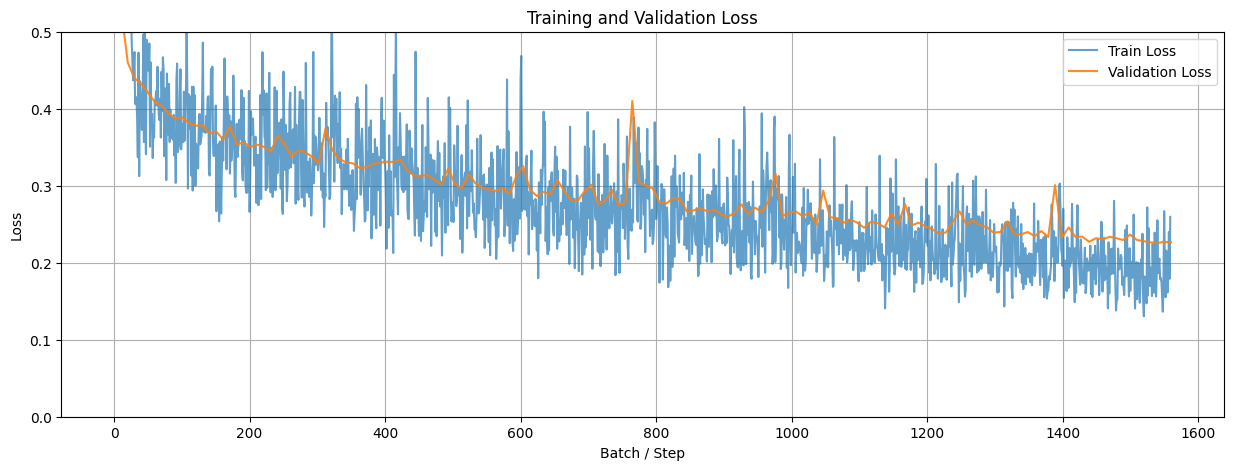

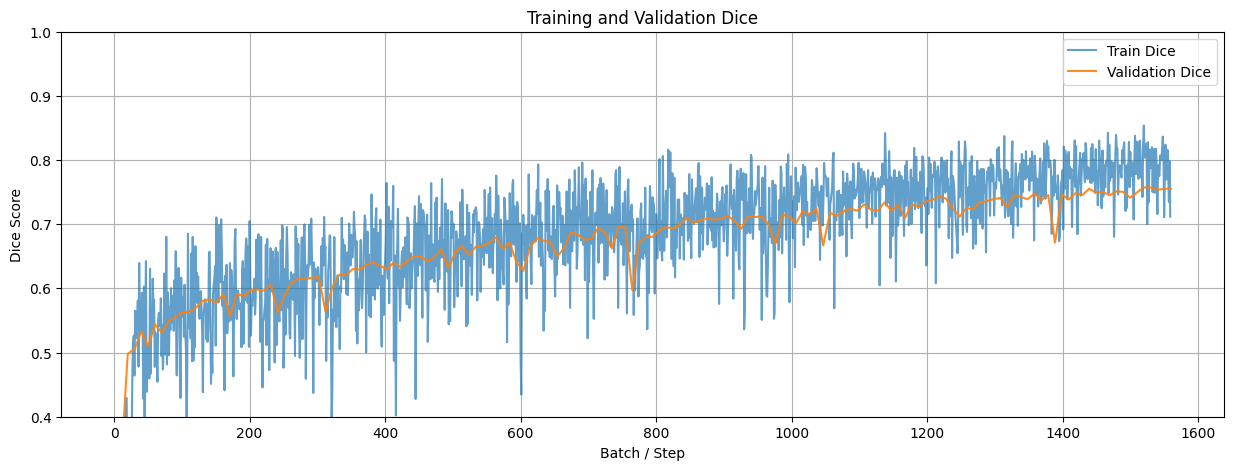

In [ ]:
# Loss plot
plt.figure(figsize=(15, 5))
plt.plot(train_losses, label='Train Loss', alpha=0.7)
plt.plot(np.linspace(0, len(train_losses), len(valid_losses)), valid_losses, label='Validation Loss', alpha=0.9)
plt.xlabel('Batch / Step')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.ylim([0 , 0.5])
plt.show()

# Dice plot
plt.figure(figsize=(15, 5))
plt.plot(train_dice_scores, label='Train Dice', alpha=0.7)
plt.plot(np.linspace(0, len(train_dice_scores), len(valid_dice_scores)), valid_dice_scores, label='Validation Dice', alpha=0.9)
plt.xlabel('Batch / Step')
plt.ylabel('Dice Score')
plt.title('Training and Validation Dice')
plt.legend()
plt.grid(True)
plt.ylim([0.4 , 1])
plt.show()

And the see how it behaves up close.

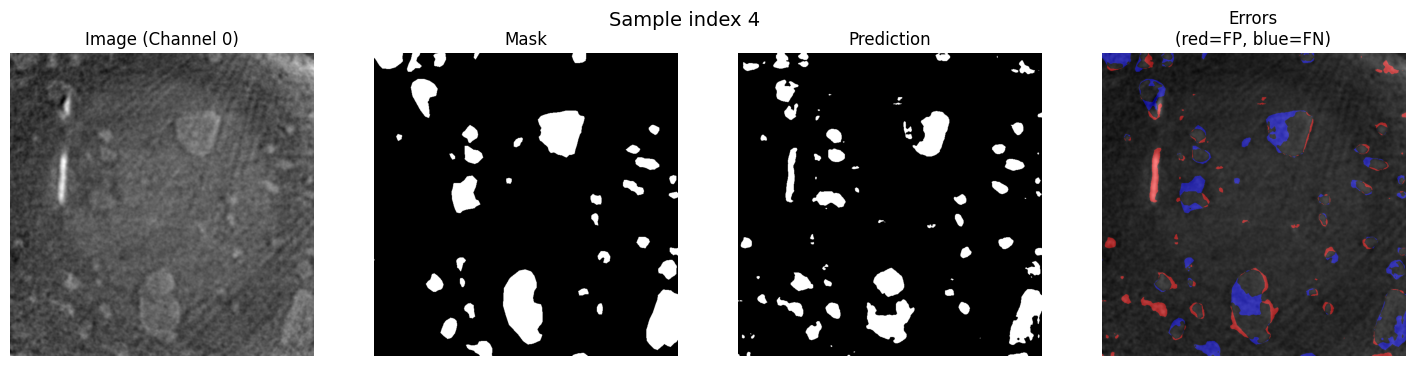

In [ ]:
model.eval()

# Choose a single test sample index
idx = np.random.randint(len(test_dataset))

# Load sample
img_tensor, gt_mask = test_dataset[idx]     # img_tensor: (4, H, W)
img = img_tensor.unsqueeze(0).to(device)    # -> (1, 4, H, W)

# Prediction
with torch.no_grad():
    output = model(img)
    pred = (torch.sigmoid(output) > 0.5).float().squeeze().cpu().numpy()

# Extract ONLY the first channel (raw image)
img_np = img_tensor[0].numpy()              # <--- IMPORTANT FIX
gt_np  = gt_mask.squeeze().numpy()

# Intersection (True Positives)
intersection = pred * gt_np

# Error regions
false_pos = (pred == 1) & (gt_np == 0)  # red
false_neg = (pred == 0) & (gt_np == 1)  # blue

error_map = np.zeros((*gt_np.shape, 3))
error_map[false_pos] = [1, 0, 0]  # red
error_map[false_neg] = [0, 0, 1]  # blue

# Plot all 4 images
plt.figure(figsize=(18,4))
plt.suptitle(f"Sample index {idx}", fontsize=14)

# Raw image (channel 0)
plt.subplot(1,4,1)
plt.imshow(img_np, cmap="gray")
plt.title("Image (Channel 0)")
plt.axis("off")

# Ground truth
plt.subplot(1,4,2)
plt.imshow(gt_np, cmap="gray")
plt.title("Mask")
plt.axis("off")

# Prediction
plt.subplot(1,4,3)
plt.imshow(pred, cmap="gray")
plt.title("Prediction")
plt.axis("off")

# Intersection + Error overlay
plt.subplot(1,4,4)
plt.imshow(img_np, cmap="gray")
plt.imshow(error_map, alpha=0.5)
plt.title("Errors\n(red=FP, blue=FN)")
plt.axis("off")

plt.show()

##### Step 4
Now we compute the semi-supervised portion of the pipeline (with the unlabelled data), like in week 3. Below we include the function that creates the dynamic confidence threshold.

In [ ]:
def generate_pseudo_labels(model, images, epoch, max_epochs, min_thr=0.5, max_thr=0.9):
    model.eval()
    with torch.no_grad():
        logits = model(images)              # [B, 1, H, W] or [B, C, H, W]
        probs  = torch.sigmoid(logits)      # keep as 4D

    # Threshold schedule
    thr = min_thr + (max_thr - min_thr) * (epoch / max_epochs)

    # Pseudo mask (binary)
    pseudo_mask = (probs > 0.5).float()

    # Confidence mask
    high_conf = probs > thr
    low_conf  = probs < (1 - thr)
    confidence_mask = high_conf | low_conf    # still 4D

    # Filter: keep confident pixels, set rest to -1
    pseudo_mask_filtered = pseudo_mask.clone()
    pseudo_mask_filtered[~confidence_mask] = -1.0

    return pseudo_mask_filtered

class UnlabeledTensorDataset(Dataset):
    def __init__(self, tensors):
        self.tensors = tensors

    def __len__(self):
        return len(self.tensors)

    def __getitem__(self, idx):
        return self.tensors[idx]

unlabeled_dataset = UnlabeledTensorDataset(unlabelled_image_list)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=2, shuffle=True)

And below we have the training loop.

In [ ]:
# Move model to device
model = model.to(device)

# Optimizer and loss
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)  # Only update the parameters whose requires_grad == True
loss_fn = combined_loss

# Training parameters
num_epochs = 30
validation_every_steps = 10
k = 2 # two unlabeled image for every labeled one
step = 0

# For tracking metrics (we also compute the loss)
train_dice_scores_l = []
valid_dice_scores = []
train_losses_l = []
valid_losses = []

train_losses_u = []

# For keeping the pseudo labels as they evolve in training
idx_u = 6
image_unlabeled = unlabelled_image_list[idx_u]
pseudo_labels_idx_u = []

# To do the load without adding a batch size, chat
def pseudo_iter_generator(pseudo_dataset):
    while True:
        for item in pseudo_dataset:
            yield item

# Training routine
best_val_dice = 0.0

for epoch in range(num_epochs):
    model.train()
    pseudo_dataset = []

    for i, unlabeled in enumerate(unlabeled_loader):
      unlabeled = unlabeled.to(device)

      if unlabeled.dim() == 5 and unlabeled.shape[1] == 1:
        unlabeled = unlabeled.squeeze(1)   # [B, 4, H, W]

      pseudo_mask = generate_pseudo_labels(model, unlabeled, epoch, num_epochs)

      if i == idx_u:
        pseudo_labels_idx_u.append(pseudo_mask.cpu().numpy()) #cpu.() because we cant put .numpy() directly on GPU tensor

      pseudo_dataset.append((unlabeled, pseudo_mask))

    pseudo_iter = pseudo_iter_generator(pseudo_dataset)

    lambda_u = 0.1 + (0.5-0.1)*(epoch/num_epochs)

    for imgs_l, masks_l in train_loader:
        imgs_l, masks_l = imgs_l.to(device), masks_l.to(device)

        # Forward pass
        output_l = model(imgs_l)
        loss_l = loss_fn(output_l, masks_l)

        # Compute Dice for this batch
        preds_l = (torch.sigmoid(output_l) > 0.5).float()
        batch_dice_l = dice_coefficient(preds_l, masks_l)
        train_dice_scores_l.append(batch_dice_l)
        train_losses_l.append(loss_l.item())

        step += 1

        loss_u_total = 0

        for _ in range(k):
            imgs_u, pseudo_masks = next(pseudo_iter)
            imgs_u, pseudo_masks = imgs_u.to(device), pseudo_masks.to(device)

            # Forward pass
            output_u = model(imgs_u)
            loss_u = loss_fn(output_u, pseudo_masks)

            loss_u_total += loss_u

            train_losses_u.append(loss_u.item())

        # Backward pass and optimizer step
        loss_total = loss_l + lambda_u * (loss_u_total/k)

        optimizer.zero_grad()
        loss_total.backward()
        optimizer.step()


        # Validation every N steps
        if step % validation_every_steps == 0:
            model.eval()
            val_dice_list = []
            val_loss_list = []

            with torch.no_grad():
                for val_imgs, val_masks in val_loader:
                    val_imgs, val_masks = val_imgs.to(device), val_masks.to(device)
                    val_output = model(val_imgs)
                    val_loss = loss_fn(val_output, val_masks)

                    val_preds = (torch.sigmoid(val_output) > 0.5).float()
                    val_dice = dice_coefficient(val_preds, val_masks)

                    val_dice_list.append(val_dice)
                    val_loss_list.append(val_loss.item())

            mean_val_dice = np.mean(val_dice_list)
            mean_val_loss = np.mean(val_loss_list)
            valid_dice_scores.append(mean_val_dice)
            valid_losses.append(mean_val_loss)

            print(f"Epoch {epoch+1}, Step {step} | Train Dice: {batch_dice_l:.4f} | Val Dice: {mean_val_dice:.4f} | Val Loss: {mean_val_loss:.4f} | Pseudo Loss: {loss_u_total:.4f}")

            # Save the best model
            if mean_val_dice > best_val_dice:
                best_val_dice = mean_val_dice
                torch.save({
                     'model_state_dict': model.state_dict(),
                     'optimizer_state_dict': optimizer.state_dict(),
                     'epoch': epoch+1
                 }, "/content/drive/MyDrive/dl_p21_data/fine_tuned_checkpoint_unl_tensor.pth")

            model.train()

print("Finished training.")

OutOfMemoryError: CUDA out of memory. Tried to allocate 576.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 172.12 MiB is free. Process 8992 has 14.57 GiB memory in use. Of the allocated memory 12.98 GiB is allocated by PyTorch, and 1.48 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

We can then see the test dice score.

In [ ]:
# Uploading the weights from Drive
weights_path = "/content/drive/MyDrive/dl_p21_data/fine_tuned_checkpoint_unl_tensor.pth"

device = "cuda" if torch.cuda.is_available() else "cpu"

# Creates a new model and uploads the weights to it
model = UNet(num_classes=1).to(device)

checkpoint = torch.load(weights_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])

print("Weights loaded successfully")

# Testing result
model.eval()
test_dice_values = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        preds = (torch.sigmoid(output) > 0.5).float()
        dice = dice_coefficient(preds, targets)
        test_dice_values.append(dice)

mean_test_dice = np.mean(test_dice_values)
var_test_dice  = np.var(test_dice_values)

print(f"Test dice score (mean): {mean_test_dice:.3f}       Test dice score (var): {var_test_dice:.3f}")

Weights loaded successfully
Test dice score (mean): 0.829       Test dice score (var): 0.002


And hoe the model progresses.

In [ ]:
# Loss plot
plt.figure(figsize=(15, 5))
plt.plot(train_losses, label='Train Loss', alpha=0.7)
plt.plot(np.linspace(0, len(train_losses), len(valid_losses)), valid_losses, label='Validation Loss', alpha=0.9)
plt.xlabel('Batch / Step')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.ylim([0 , 0.5])
plt.show()

# Dice plot
plt.figure(figsize=(15, 5))
plt.plot(train_dice_scores, label='Train Dice', alpha=0.7)
plt.plot(np.linspace(0, len(train_dice_scores), len(valid_dice_scores)), valid_dice_scores, label='Validation Dice', alpha=0.9)
plt.xlabel('Batch / Step')
plt.ylabel('Dice Score')
plt.title('Training and Validation Dice')
plt.legend()
plt.grid(True)
plt.ylim([0.4 , 1])
plt.show()

NameError: name 'train_losses' is not defined

<Figure size 1500x500 with 0 Axes>

And finnaly we can see how the model labels each sample.

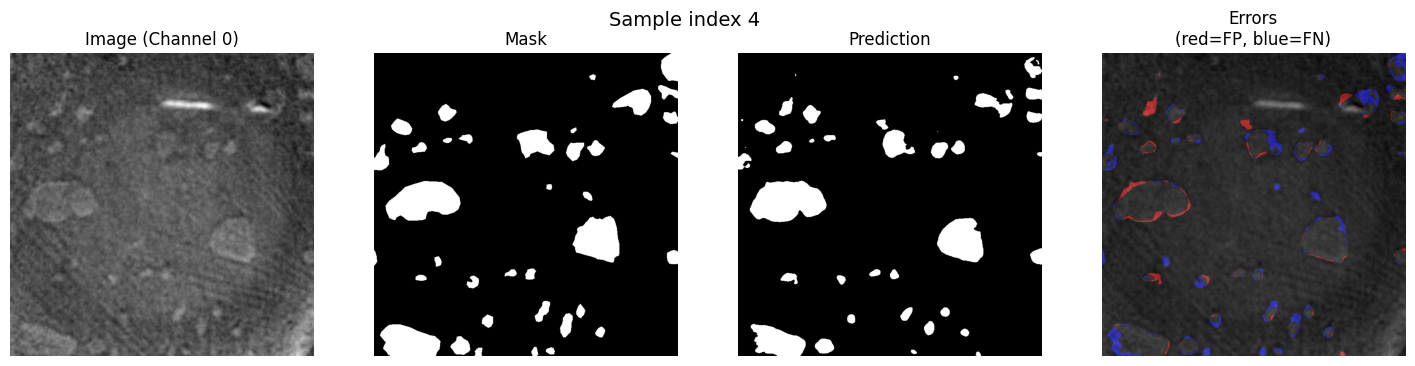

In [ ]:
model.eval()

# Choose a single test sample index
idx = np.random.randint(len(test_dataset))

# Load sample
img_tensor, gt_mask = test_dataset[idx]     # img_tensor: (4, H, W)
img = img_tensor.unsqueeze(0).to(device)    # -> (1, 4, H, W)

# Prediction
with torch.no_grad():
    output = model(img)
    pred = (torch.sigmoid(output) > 0.5).float().squeeze().cpu().numpy()

# Extract ONLY the first channel (raw image)
img_np = img_tensor[0].numpy()              # <--- IMPORTANT FIX
gt_np  = gt_mask.squeeze().numpy()

# Intersection (True Positives)
intersection = pred * gt_np

# Error regions
false_pos = (pred == 1) & (gt_np == 0)  # red
false_neg = (pred == 0) & (gt_np == 1)  # blue

error_map = np.zeros((*gt_np.shape, 3))
error_map[false_pos] = [1, 0, 0]  # red
error_map[false_neg] = [0, 0, 1]  # blue

# Plot all 4 images
plt.figure(figsize=(18,4))
plt.suptitle(f"Sample index {idx}", fontsize=14)

# Raw image (channel 0)
plt.subplot(1,4,1)
plt.imshow(img_np, cmap="gray")
plt.title("Image (Channel 0)")
plt.axis("off")

# Ground truth
plt.subplot(1,4,2)
plt.imshow(gt_np, cmap="gray")
plt.title("Mask")
plt.axis("off")

# Prediction
plt.subplot(1,4,3)
plt.imshow(pred, cmap="gray")
plt.title("Prediction")
plt.axis("off")

# Intersection + Error overlay
plt.subplot(1,4,4)
plt.imshow(img_np, cmap="gray")
plt.imshow(error_map, alpha=0.5)
plt.title("Errors\n(red=FP, blue=FN)")
plt.axis("off")

plt.show()

And that's it :)